# One-Asset HANK Tutorial

The package supports heterogeneous agent models with and without porfolio chocie (i.e., with one asset and two assets, respectively). Both examples are keept relatively close to the ones used in the [Sequence-Space Jacobian package](https://github.com/shade-econ/sequence-jacobian) for reasons of comparability. 

While for models without heterogenous agents, the calculation of the sequence-space jacobian for the nonlinear extended path is already speed and memmory optimized, this is not yet the case for HANK (but would be relatively straightforward). 

Start with some misc imports and load the package:

In [1]:
import jax.numpy as jnp # use jax.numpy instead of normal numpy. Yes, this is one of the reasons why it is nice not to have all numpy objects imported on the lowest hirarchy
from grgrlib import figurator, grplot # a nice backend for batch plotting with matplotlib
import econpizza as ep # pizza
import matplotlib.pyplot as plt

# for nicer text in figures
plt.rc('text', usetex=True)
# only necessary if you run this in a jupyter notebook:
%matplotlib inline 

The provided example is the same model as used by [Auclert et al., 2022](http://mattrognlie.com/sequence_space_jacobian.pdf), which is documented [in this notebook](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb) (and in the appendix of their paper). 
There are some deviations. 

First, I use GHH preferences (Greenwood et al., 1988):
$$ 
u(c_{i,t}, n_{i,t}; z_{i,t}) = \frac{x_{i,t}^{1-\sigma}}{1-\sigma},
$$

with the composite good $x_{i,t}$ defined as 
$$
x_{i,t} = c_{i,t} - z_{i,t} \frac{n_{i,t}^{1 + \varphi}}{1+\varphi}.
$$

A version with standard preferences and individual labor choice as in Auclert et al. (2022) is provided as `example_hank_labor`, which links to [this yaml file](https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank_labor.yaml).

Second, the NK-Phillips Curve is the conventional nonlinear Phillips Curve as derived from Rothemberg pricing,

$$
     \psi\left(\frac{\pi_t}{\pi_{SS}} - 1\right)\frac{\pi_t}{\pi_{SS}} = (1-\theta) + \theta w_t + E_t\left\{ \psi \frac{\pi_{t+1}}{R_t}\left(\frac{\pi_{t+1}}{\pi_{SS}} - 1\right) \frac{\pi_{t+1}}{\pi_{SS}}\frac{Y^p_{t+1}}{Y^p_t}\right\},
$$

 where the inverse real rate $\frac{\pi_{t+1}}{R_t}$ is used to avoid a representative household discount factor (e.g, $\beta_{t+1} \frac{C_t}{C_{t+1}}$).
 
Third, the central bank sets the *shadow rate* to follow a conventional monetary policy rule with interest rate inertia,
$$
    R_{s,t} = \left[R^*\left(\frac{\pi_t}{\pi_{SS}}\right)^{\phi_\pi} \left(\frac{Y_t}{Y_{t-1}}\right)^{\phi_y}\right]^{1-\rho} R_{s,t-1}^\rho,
$$

and the actual nominal interest rate equals this *shadow rate* subject to the zero lower bound on nominal interest rates,
$$
R_t = \max\left\{1, R_{s,t}\right\}
$$

Details can be found in the section on the `yaml` file [above](https://econpizza.readthedocs.io/en/latest/tutorial.html#the-yaml-file).

Load the example file:

In [2]:
from econpizza import example_hank

`example_hank` is nothing else than the path to the yaml file we discussed before:

In [3]:
print(example_hank)

/home/gboehl/github/econpizza/econpizza/examples/hank.yaml


Parse the example hank model from the yaml and compile the model:

In [4]:
# parse model
hank1_dict = ep.parse(example_hank)
# compile the model
hank1 = ep.load(hank1_dict)

(load:) Parsing done.


The first step creates a raw dictionary from the yaml. The second translates everything to a model instance with compiled and tested functions. If something specific in your model does not work, you should have been informed by now.

Lets continue with the steady state:

In [5]:
stst_result = hank1.solve_stst()

    Iteration   1 | max error 8.60e-01 | lapsed 4.7522
    Iteration   2 | max error 3.97e-01 | lapsed 4.8492
    Iteration   3 | max error 4.42e-01 | lapsed 4.8872
    Iteration   4 | max error 2.06e-02 | lapsed 4.9225
    Iteration   5 | max error 3.60e-03 | lapsed 4.9550
    Iteration   6 | max error 8.86e-05 | lapsed 4.9891
    Iteration   7 | max error 5.27e-08 | lapsed 5.0216
(solve_stst:) Steady state found (5.6317s). The solution converged.


By default, the final message is rather verbose. The rank of the Jacobian is important because quite often, the steady state is indetermined and you need to fix some steady state values. Econpizza can deal with that by using the Pseudoinverse during the Newton steps. Fixing some of the variables is also what I did here. Since the function has 12 degrees of freedom and 6 fixed variables for a total of 18 variables, we're fine and the steady state solver nicely converges.

The resulting `stst_result` is similar to the return object from `scipy.optimize.root` and contains all sorts of nice information to help you debugging if you have problems finding the steady state:

In [6]:
print(stst_result.keys())

dict_keys(['success', 'message', 'x', 'niter', 'fun', 'jac', 'det'])


In [7]:
print(stst_result['fun']) # the steady state function at the solution x

[-1.50511825e-09  5.96744876e-15  2.33146835e-15 -1.11022302e-16
 -1.50509336e-09  1.50509327e-09 -2.22044605e-16  0.00000000e+00
  1.24359332e-16  0.00000000e+00  1.50509315e-09  1.50509361e-09
  2.05027106e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


The Pizza automatically stores the steady state values as a dictionary in the model object:

In [8]:
hank1['stst']

{'B': DeviceArray(5.6, dtype=float64),
 'beta': DeviceArray(0.97, dtype=float64),
 'C': DeviceArray(1., dtype=float64),
 'Div': DeviceArray(0.23927422, dtype=float64),
 'n': DeviceArray(0.91287093, dtype=float64),
 'pi': DeviceArray(1., dtype=float64),
 'R': DeviceArray(1.01427653, dtype=float64),
 'Rn': DeviceArray(1.01427653, dtype=float64),
 'Rs': DeviceArray(1.01427653, dtype=float64),
 'Rstar': DeviceArray(1.01427653, dtype=float64),
 'Tax': DeviceArray(0.07994855, dtype=float64),
 'Top10A': DeviceArray(0.31317355, dtype=float64),
 'Top10C': DeviceArray(0.24153053, dtype=float64),
 'w': DeviceArray(0.83333333, dtype=float64),
 'Y': DeviceArray(1., dtype=float64),
 'Yprod': DeviceArray(1., dtype=float64),
 'Z': DeviceArray(1.09544511, dtype=float64)}

Let us, out of curiousity, have a look at the steady state distribution. It is stored under `hank1['steady_state']`. Note that at the same location, also steady state `decisions` (the value function) are stored.

In [9]:
dist = hank1['steady_state']['distributions'][0]
grid = hank1['context']['a_grid']

Under the dict behind the `context` keyword, many other model specific variables are stored. Better have a look youself if you care. For those who really miss Dynare and the global access to model variables and objects, you can simply add the model context to globals:

In [10]:
globals().update(hank1['context'])
print(a_grid) # this is now available while it was not before

[0.00000000e+00 3.64153686e-02 7.81350535e-02 1.25931689e-01
 1.80690453e-01 2.43425460e-01 3.15298540e-01 3.97640759e-01
 4.91977066e-01 6.00054540e-01 7.23874738e-01 8.65730768e-01
 1.02824976e+00 1.21444150e+00 1.42775421e+00 1.67213836e+00
 1.95211987e+00 2.27288390e+00 2.64037088e+00 3.06138657e+00
 3.54372802e+00 4.09632803e+00 4.72942058e+00 5.45473033e+00
 6.28568976e+00 7.23768797e+00 8.32835564e+00 9.57789157e+00
 1.10094367e+01 1.26495029e+01 1.45284635e+01 1.66811163e+01
 1.91473277e+01 2.19727710e+01 2.52097726e+01 2.89182806e+01
 3.31669754e+01 3.80345413e+01 4.36111240e+01 5.00000000e+01]


Let's plot the distribution:

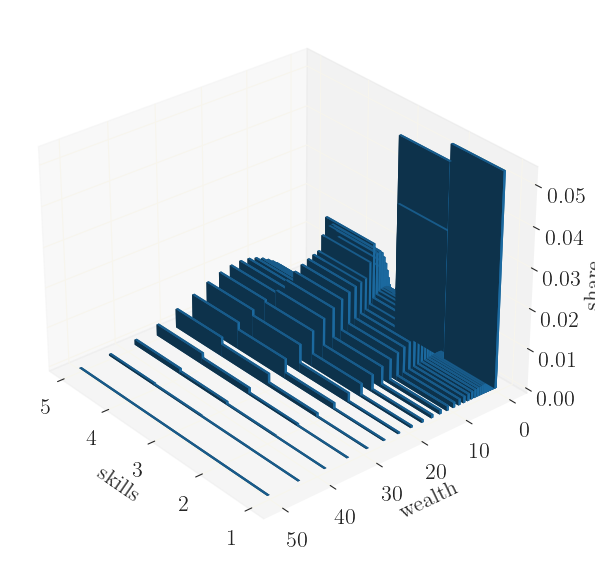

In [11]:
from grgrlib import grbar3d # a nice backend to 3D-plots with matplotlib

ax, _ = grbar3d(dist, xedges=jnp.arange(1,5), yedges=grid, figsize=(9,7), depth=.5) # create 3D plot
# set axis labels
ax.set_xlabel('skills')
ax.set_ylabel('wealth')
ax.set_zlabel('share')
# rotate
ax.view_init(azim=140)

Nice. As expected, agents with higher income hold more assets, and vice versa.

Okay, let's continue with calculating some impulse response functions. We'll have a look at a shock to the households' discount factor $\beta$. 


Find the *nonlinear* IRFs (I'll show below how to find the linear IRFs):

In [12]:
# define the shock as (shock_name, value)
shock = ('e_beta', 0.05)
# simulate
xst, flags = hank1.find_path(shock)

(get_derivatives:) Derivatives calculation done (6.085s).
(get_jacobian:) Jacobian accumulation and decomposition done (2.756s).
    Iteration  10 | max error 1.43e-02 | dampening 0.392 | lapsed 9.5633s
    Iteration  20 | max error 7.90e-05 | dampening 0.238 | lapsed 10.2933s
    Iteration  30 | max error 2.06e-07 | dampening 0.228 | lapsed 10.9876s
    Iteration  36 | max error 6.07e-09 | dampening 0.226 | lapsed 11.4408s
(find_path:) Stacking done (20.425s). The solution converged.


Alternatively, take the steady state as the initial value, and alter the initial value of $\beta$ directly. Also that a second run will be much faster because all objects are already compiled:

In [13]:
# this is a dict containing the steady state values
x0 = hank1['stst'].copy()
# setting a large shock on the discount factor
x0['beta'] = 1.03

# simulate again with the different initial state:
xst, flags = hank1.find_path(x0=x0.values())

    Iteration  10 | max error 6.67e-02 | dampening 0.192 | lapsed 0.7267s
    Iteration  20 | max error 5.89e-04 | dampening 0.193 | lapsed 1.4827s
    Iteration  30 | max error 4.14e-06 | dampening 0.221 | lapsed 2.2687s
    Iteration  40 | max error 2.09e-08 | dampening 0.220 | lapsed 2.9972s
    Iteration  42 | max error 7.34e-09 | dampening 0.220 | lapsed 3.2076s
(find_path:) Stacking done (3.222s). The solution converged.


That went smoothly. Again, you will get (hopefully) meaningful and (hopefully) infomative final messages. Let's plot only a few of the variables for space restrictions: output $y_t$ (`Y`), inflation $\pi_t$ (`pi`), the nominal interst rate $R_t$ (`Rn`), and the percentage share of wealth held by the top-10% richest, `Top10A`.

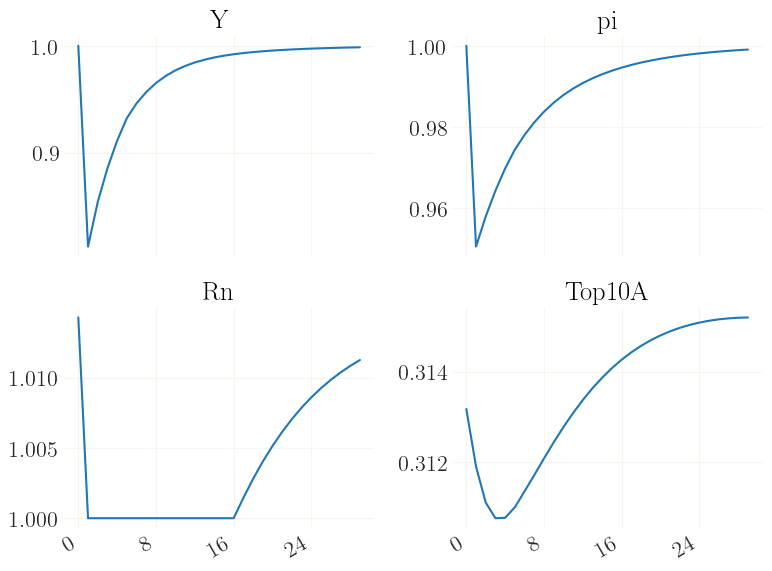

In [14]:
# this is how *all* aggregate variables could be plotted:
#grplot(xst[:30], labels=hank1['variables']) 

variables = 'Y', 'pi', 'Rn', 'Top10A'
inds = [hank1['variables'].index(v) for v in variables] # get indices of variables

_ = grplot(xst[:30, inds], labels=variables)

See how the effective lower bound is binding for quite a while, and how the endogenous distribution adjusts accordingly. 

In case you want to study the distributional dynamics in detail, you can also back out the exact *nonlinear sequences* of the disaggregated variables and their distribution. That is, their complete history given the trajectory ``xst`` of aggregated variables.

In [15]:
# note that the sequence of aggregated variables is the input
het_vars = hank1.get_distributions(xst)

The function will return a dictionary with the disaggregated variables (``outputs`` of the decision stage) and the distribution as key:

In [16]:
print(het_vars.keys())

dict_keys(['a', 'c', 'dist'])


Each of the objects has shape ``*distribution shape, number_of_periods``:

In [17]:
print(het_vars['a'].shape)

(4, 40, 299)


For example, we can use this to plot the distribution of wealth over time:

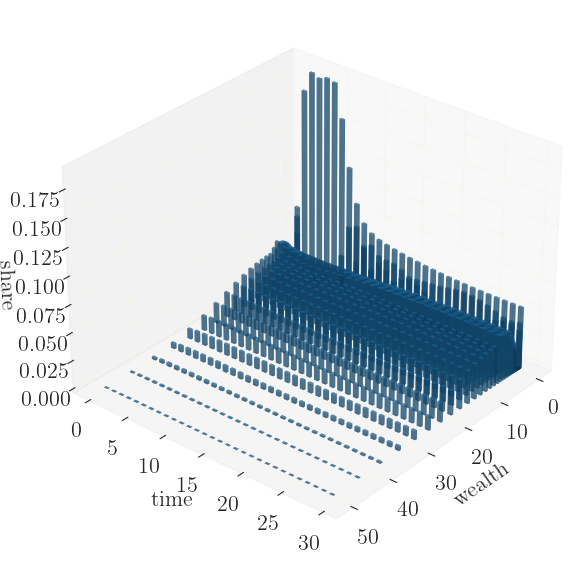

In [18]:
dist = het_vars['dist']
a_grid = hank1['context']['a_grid']
# plot
ax, _ = grbar3d(dist[...,:30].sum(0), xedges=a_grid, yedges=jnp.arange(30), figsize=(9,7), depth=.5, width=.5, alpha=.5)
# set axis labels
ax.set_xlabel('wealth')
ax.set_ylabel('time')
ax.set_zlabel('share')
# rotate
ax.view_init(azim=40) 

The graph shows that the discount factor shock (and the ZLB) mainly affects the wealth of the housholds which hold no or very few liquid assets, causing them to hold more assets.